In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
import warnings

# Игнорирование предупреждений
warnings.filterwarnings('ignore')

# Визуализация встроенная в блокнот
%matplotlib inline


In [9]:
import pandas as pd

# Загрузка данных
train = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv')
test = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv')
census = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/census_starter.csv')
sample = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/sample_submission.csv')
train_revealed = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/revealed_test.csv')

# Объединение двух датасетов
train = pd.concat([train, train_revealed])
print('Concatenated train data shape:', train.shape)


Concatenated train data shape: (128535, 7)


In [10]:
train.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


# Метрика

В этом сорвеновании у нас метрика SMAPE:
$${\rm SMAPE} = \frac{100}{n} \sum_{i=1}^n \frac{|F_i - A_i|}{(|F_i| + |A_i|) / 2}, $$
Здесь $A_i$ и $F_i$ - верное значение и предсказанное соответственно

In [11]:
import numpy as np

def smape_one(y_true, y_pred):
    """
    Вычисляет sMAPE для одного значения.
    """
    if y_true == 0 and y_pred == 0:
        return 0
    
    numinator = np.abs(y_true - y_pred)
    denominator = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    return 100 * numinator / denominator


def smape(y_true, y_pred):
    """
    Вычисляет среднее sMAPE для массивов y_true и y_pred.
    """
    numinator = np.abs(y_true - y_pred)
    denominator = ((np.abs(y_true) + np.abs(y_pred)) / 2)

    smape = np.where((y_true != 0) | (y_pred != 0), numinator / denominator, 0)
    
    return 100 * np.mean(smape)

def smape_vector(y_true, y_pred):
    """
    Вычисляет векторизованное sMAPE для массивов y_true и y_pred.
    """
    numinator = np.abs(y_true - y_pred)
    denominator = ((np.abs(y_true) + np.abs(y_pred)) / 2)

    smape = np.where((y_true != 0) | (y_pred != 0), numinator / denominator, 0)
    
    return 100 * smape


In [12]:
y_true = 100

plot_data = []
for percent_error in np.linspace(-100, 500, 5000):
    y_pred = (1 + percent_error / 100) * y_true
    smape = smape_one(y_true=y_true, y_pred=y_pred)
    
    plot_data.append({'percent_error': percent_error, 'loss': smape, 'metric': 'SMAPE'})
    
df_plot_data = pd.DataFrame(plot_data)

fig = px.line(
    df_plot_data, 
    x="percent_error", 
    y="loss", 
    color='metric',
    title='SMAPE behaviour')

fig.update_layout(autosize=False, width=600, height=600, showlegend=True)

fig.show()

In [13]:
import numpy as np
import pandas as pd
import plotly.express as px

y_true = 100

plot_data = []
for percent_error in np.linspace(0, 100, 5000):
    y_pred_over_forecast = (1 + percent_error / 100) * y_true
    y_pred_under_forecast = (1 - percent_error / 100) * y_true
    
    smape_over_forecast = smape_one(y_true=y_true, y_pred=y_pred_over_forecast)
    smape_under_forecast = smape_one(y_true=y_true, y_pred=y_pred_under_forecast)
    
    loss_ratio = smape_over_forecast / smape_under_forecast
    
    plot_data.append({'percent_error': percent_error, 'loss_ratio': loss_ratio})
    
df_plot_data = pd.DataFrame(plot_data)

fig = px.line(
    df_plot_data, 
    x="percent_error", 
    y="loss_ratio", 
    title='SMAPE Loss Ratio (Over Forecast / Under Forecast)'
)

fig.update_layout(autosize=False, width=600, height=600, showlegend=True)

fig.show()


### Особенности метрики

* SMAPE не симметрична для завышения и занижений предсказаний: завышение предсказания относительно занижения дает меньшую ошибку, так же максимальное значение SMAPE = 200

# EDA

In [14]:
# Преобразование столбца 'first_day_of_month' в формат даты
train['first_day_of_month'] = pd.to_datetime(train['first_day_of_month'])

# Сортировка данных по 'cfips' и 'first_day_of_month'
train = train.sort_values(['cfips', 'first_day_of_month'])

# Рассчет столбца 'pop' (население) и добавление его в DataFrame
train['pop'] = (100 * train['active'] / train['microbusiness_density']).round()

# Извлечение года из столбца 'first_day_of_month' и добавление его в DataFrame
train['year'] = train['first_day_of_month'].dt.year

train.head()


,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,pop,year
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,41527.0,2019
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,41527.0,2019
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,41527.0,2019
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,41527.0,2019
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,41527.0,2019


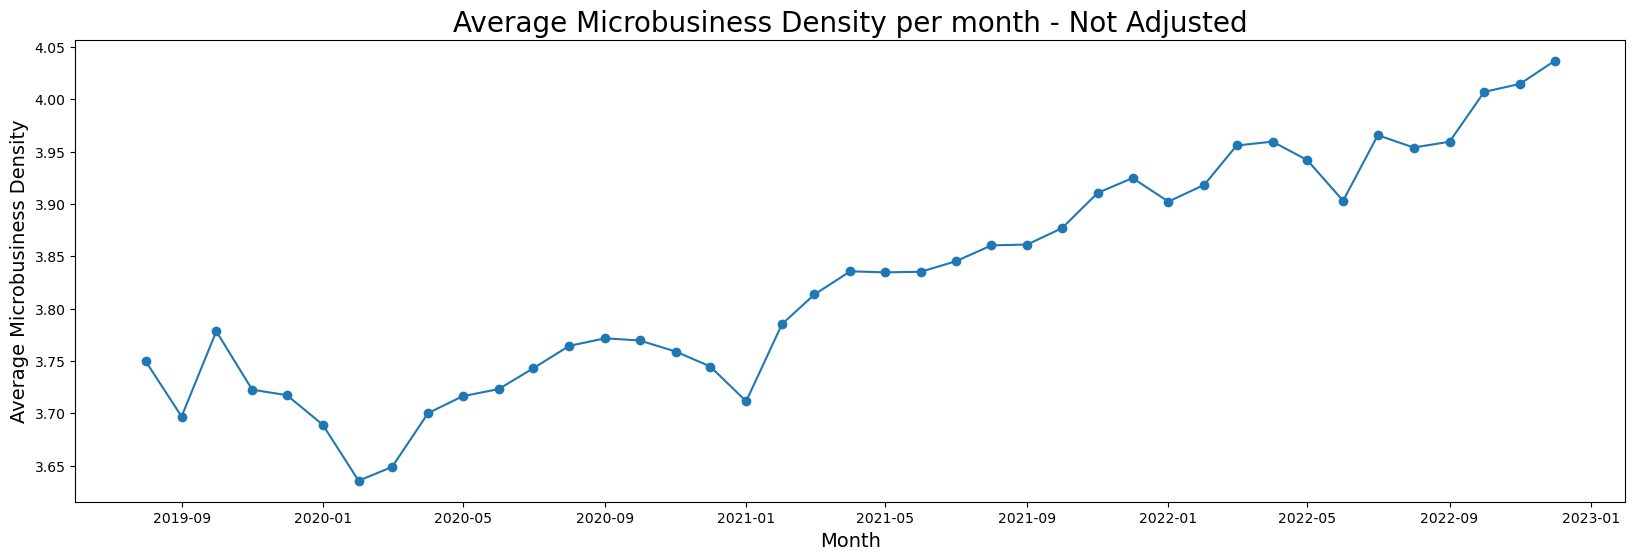

In [15]:
# Группировка данных по 'first_day_of_month' и вычисление среднего значения 'microbusiness_density'
monthly_avg_density = train.groupby('first_day_of_month')['microbusiness_density'].mean()

plt.figure(figsize=(20, 6))
plt.plot(monthly_avg_density.index, monthly_avg_density, '-o')

plt.title('Average Microbusiness Density per month - Not Adjusted', size=20)
plt.xlabel('Month', size=14)
plt.ylabel('Average Microbusiness Density', size=14)

plt.show()


In [17]:
# Создание отстающих признаков для 'microbusiness_density' с помощью сдвигов
for lag in [-1, 1]:
    # Используем функцию shift для сдвига значений 'microbusiness_density' на указанный лаг
    train[f'microbusiness_density_lag_{lag}'] = train.groupby('cfips')['microbusiness_density'].shift(lag)


In [18]:
# Создание признака 'is_equal_to_lag', указывающего, равно ли текущее значение 'microbusiness_density' предыдущему лагу
train['is_equal_to_lag'] = train['microbusiness_density'] == train['microbusiness_density_lag_1']

# Фильтрация данных для строк, где 'is_equal_to_lag' не является NaN (notnull)
df_agg = train[train['is_equal_to_lag'].notnull()].\
            groupby('first_day_of_month', as_index=False).agg(mean_is_equal_to_lag=('is_equal_to_lag', 'mean'))

fig = px.line(
    df_agg, 
    x="first_day_of_month", 
    y="mean_is_equal_to_lag", 
    title='Share of equal to previous microbusiness_density'
)

fig.show()


Видим, что в январе доля оставшейся плотности стремится к нулю, потому что в это время обновляются данные о численности населения в каждом регионе.

Так же наши предсказания сильно зависят от актуальности данных о населении, поэтому нужно обновить данные используя более актуальный датасет 'census' для 2021 года.

In [109]:
# adults = {}
# COLS = ['GEO_ID','NAME','S0101_C01_026E']

# for k in [2017,2018,2019,2020,2021]:
#     df2021 = pd.read_csv(f'/kaggle/input/census-data-for-godaddy/ACSST5Y{k}.S0101-Data.csv',usecols=COLS)
#     df2021 = df2021.iloc[1:]
#     df2021['S0101_C01_026E'] = df2021['S0101_C01_026E'].astype('int')
#     df2021['cfips'] = df2021.GEO_ID.apply(lambda x: int(x.split('US')[-1]) )
#     adults[k] = df2021.set_index('cfips').S0101_C01_026E.to_dict()
    
# train['adult2021'] = train.cfips.map(adults[2021])
# for k in [2019,2020,2021,2022]:
#     train['adults'] = train.cfips.map(adults[k-2])
#     train.loc[train.year==k,'microbusiness_density'] *=\
#          train.adults / train.adult2021

## Посмотрим на значение метрики

In [110]:
# Выбор данных для валидации в заданном временном интервале
valid_data = train[(train.first_day_of_month >= '2022-02-01') & (train.first_day_of_month <= '2022-11-01')]

# Вычисление SMAPE для валидационных данных
valid_data['smape'] = smape_vector(
    y_true=valid_data['microbusiness_density_lag_-1'],
    y_pred=valid_data['microbusiness_density']
)

# Агрегирование по первому дню месяца и вычисление среднего SMAPE
df_agg = valid_data.groupby('first_day_of_month', as_index=False).agg(mean_smape=('smape', 'mean'))

# Построение графика с использованием Plotly Express
fig = px.line(
    df_agg, 
    x="first_day_of_month", 
    y="mean_smape", 
    title='Mean SMAPE'
)

# Отображение графика
fig.show()


In [111]:
# Агрегирование данных по 'cfips' и 'state' с вычислением среднего значения SMAPE
df_agg_cfips_loss = valid_data.groupby(['cfips', 'state'], as_index=False)['smape'].mean().sort_values('smape', ascending=False)


In [112]:
# Сопоставление штатов и их кодов
code = {'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA', 'Colorado': 'CO',
        'Connecticut': 'CT', 'Delaware': 'DE', 'District of Columbia': 'DC', 'Florida': 'FL', 'Georgia': 'GA',
        'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS',
        'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI',
        'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV',
        'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC',
        'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA',
        'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX',
        'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI',
        'Wyoming': 'WY'}

# Группировка по штатам и вычисление среднего значения SMAPE
df_agg_state_loss = valid_data.groupby(['state'], as_index=False)['smape'].mean().sort_values('smape', ascending=False)

# Сопоставление штатов с их кодами
df_agg_state_loss['code'] = df_agg_state_loss['state'].map(code)

# Построение хороплета с использованием Plotly Express
fig = px.choropleth(df_agg_state_loss,
                    locations='code',
                    color='smape',
                    range_color=(0, 2.5),
                    hover_name='state',
                    locationmode='USA-states',
                    scope='usa',
                    width=1000, height=800)

# Добавление текстовых меток с кодами штатов
fig.add_scattergeo(
    locations=df_agg_state_loss['code'],
    locationmode='USA-states',
    text=df_agg_state_loss['code'],
    mode='text')

# Отображение хороплета
fig.show()


## Разберем какой тренд прослеживается

In [19]:
# Создание нового признака 'div_mbd_over_lag' - отношение текущей 'microbusiness_density' к предыдущему лагу
train['div_mbd_over_lag'] =  train['microbusiness_density'] / train[f'microbusiness_density_lag_1']

# Фильтрация данных для строк, где предыдущий лаг больше 0
df_agg = train[train[f'microbusiness_density_lag_1'] > 0].\
            groupby('first_day_of_month', as_index=False).agg(mean_div_mbd_over_lag=('div_mbd_over_lag', 'mean'))

fig = px.line(
    df_agg, 
    x="first_day_of_month", 
    y="mean_div_mbd_over_lag", 
    title='Mean microbusiness_density over lag'
)

fig.show()


In [21]:
# Вычисление доли месяцев, в которых среднее значение 'div_mbd_over_lag' больше 1
overall_mean_greater_than_1 = np.mean(df_agg['mean_div_mbd_over_lag'] > 1)

# Вычисление доли месяцев (начиная с февраля 2022), в которых среднее значение 'div_mbd_over_lag' больше 1
since_feb_2022_mean_greater_than_1 = np.mean(df_agg[df_agg.first_day_of_month >= '2022-02-01']['mean_div_mbd_over_lag'] > 1)

print(f"Общее среднее 'mean_div_mbd_over_lag' больше 1: {overall_mean_greater_than_1}")
print(f"Среднее 'mean_div_mbd_over_lag' с февраля 2022 больше 1: {since_feb_2022_mean_greater_than_1}")


Общее среднее 'mean_div_mbd_over_lag' больше 1: 0.675
Среднее 'mean_div_mbd_over_lag' с февраля 2022 больше 1: 0.8181818181818182


Видим, что есть тренд на плавное увеличение искомой microbusiness_density

# Идея решения



В решении я использую предложенный другими пользователями Last Value Baseline - решение аналогично сезонному индексу в математической статитстике. То есть мы берем наш тренд плавного увеличения в разных регионах. Мы используем cfips для более детального разделения трендов и подберем значения для каждого. Почему мы не используем бустинги, если у нас на выходе получается табличная задача?

1) Смотря на чужие top score public notebooks видно, что все сильно переобучаются под LB, при этом CV меняется довольно нестабильно, потому что данные очень шумные

2) Бустинги не способны в экстраполяцию, а наши множество признаков просто не ограничено в каком-то диапазоне и при получении новых значений, выходящих из промежутка тренировочных значений, деревья предсказывают константу. Хочется отдельно продемонстрировать это на примере:


0.9972958108278253
0.9747014355520106
0.9392241745807616
-11.977958418581457


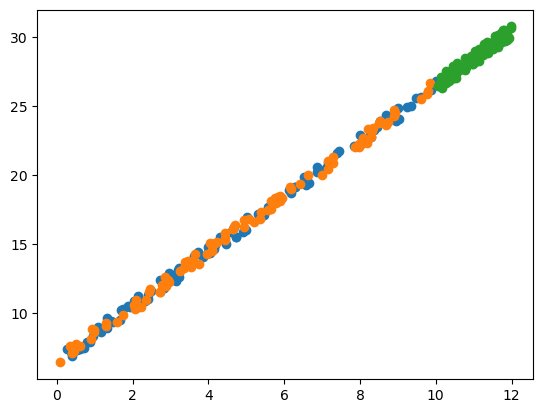

In [115]:
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

N=100
X = np.random.random(N)*10
y = X*2+6+np.random.random(N)

new_X_1 = np.random.random(N)*10
news_y_1 = new_X_1*2+6+np.random.random(N)

new_X_2 = (np.random.random(N)*2+10)
news_y_2 = new_X_2*2+6+np.random.random(N)

plt.scatter(X,y)
plt.scatter(new_X_1,news_y_1)
plt.scatter(new_X_2,news_y_2)
lr = LinearRegression()
lr.fit(X.reshape(-1,1),y)
dt = LGBMRegressor()
dt.fit(X.reshape(-1,1),y)

print(lr.score(new_X_1.reshape(-1,1),news_y_1))
print(dt.score(new_X_1.reshape(-1,1),news_y_1))

print(lr.score(new_X_2.reshape(-1,1),news_y_2))
print(dt.score(new_X_2.reshape(-1,1),news_y_2))

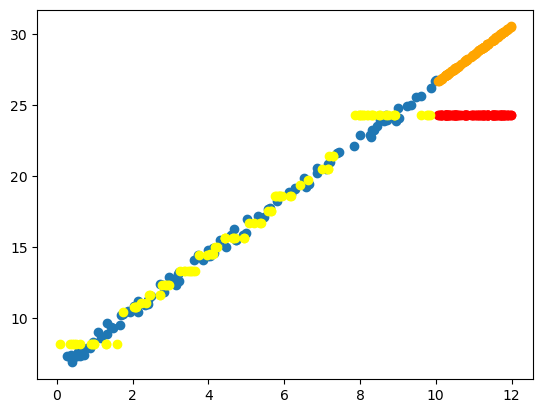

In [116]:
y_lr = lr.predict(new_X_2.reshape(-1,1))
y_dt = dt.predict(new_X_2.reshape(-1,1))
plt.scatter(X,y)
plt.scatter(new_X_2, y_lr, c='orange')
plt.scatter(new_X_2, y_dt, c='red')
y_1_dt = dt.predict(new_X_1.reshape(-1,1))
plt.scatter(new_X_1, y_1_dt, c='yellow')

## Решение

In [22]:
train_data = train[(train.first_day_of_month >= '2022-09-01') & (train.first_day_of_month <= '2022-11-01')]


Обычным перебором ищем подходящие множители

In [24]:

mult_column_to_mult = {f'smape_{mult}': mult for mult in [1.00, 1.0025, 1.005]}
mult_to_priority = {1: 1, 1.0025: 0.4, 1.005: 0.2}

for mult_column, mult in mult_column_to_mult.items():
    train_data['y_pred'] = train_data['microbusiness_density'] * mult
    train_data[mult_column] = smape_vector(
        y_true=train_data['microbusiness_density_lag_-1'],
        y_pred=train_data['y_pred']
    ) * mult_to_priority[mult]
    
df_agg = train_data.groupby('cfips')[list(mult_column_to_mult.keys())].mean()

df_agg['best_mult'] = df_agg.idxmin(axis=1).map(mult_column_to_mult)

last_active_value = train.groupby('cfips', as_index=False)['active'].last().rename(
    columns={'active': 'last_active_value'}
)
df_agg = df_agg.merge(
    last_active_value,
    on='cfips'
)
mask = df_agg['last_active_value'] < 150
df_agg.loc[mask, 'best_mult'] = 1.00

cfips_to_best_mult = dict(zip(df_agg.cfips, df_agg['best_mult']))

In [25]:
df_agg['best_mult'].value_counts(normalize=True)

1.0050    0.706858
1.0000    0.254864
1.0025    0.038278
Name: best_mult, dtype: float64

In [27]:
# Получение последнего значения 'microbusiness_density' для каждого 'cfips' из train
last_value = train.groupby('cfips')['microbusiness_density'].last().reset_index()
last_value.rename(columns={'microbusiness_density': 'last_train_value'}, inplace=True)

# Объединение значений с test по 'cfips'
submission = test.merge(last_value, on='cfips')

# Создание столбца 'forecast_month_number' с номерами месяцев прогноза
submission['forecast_month_number'] = submission.groupby('cfips').cumcount() + 1

# Применение коэффициентов из cfips_to_best_mult к значениям 'last_train_value'
submission['microbusiness_density'] = (
    submission['last_train_value'] * submission['cfips'].map(cfips_to_best_mult)
)

# Сравнение значений и вывод доли совпадающих значений
accuracy_fraction = np.mean(submission['microbusiness_density'] == submission['last_train_value'])

print(f"Доля совпадающих значений: {accuracy_fraction}")

Доля совпадающих значений: 0.25486443381180224


In [28]:
def fix_new_population_in_january(submission):
    # Загрузка данных за 2020 год
    df2020 = pd.read_csv('/kaggle/input/census-data-for-godaddy/ACSST5Y2020.S0101-Data.csv', usecols=['GEO_ID', 'NAME', 'S0101_C01_026E'])
    df2020 = df2020.iloc[1:]
    df2020['S0101_C01_026E'] = df2020['S0101_C01_026E'].astype(int)
    df2020['cfips'] = df2020['GEO_ID'].apply(lambda x: int(x.split('US')[-1]))
    adult2020 = df2020.set_index('cfips')['S0101_C01_026E'].to_dict()

    # Загрузка данных за 2021 год
    df2021 = pd.read_csv('/kaggle/input/census-data-for-godaddy/ACSST5Y2021.S0101-Data.csv', usecols=['GEO_ID', 'NAME', 'S0101_C01_026E'])
    df2021 = df2021.iloc[1:]
    df2021['S0101_C01_026E'] = df2021['S0101_C01_026E'].astype(int)
    df2021['cfips'] = df2021['GEO_ID'].apply(lambda x: int(x.split('US')[-1]))
    adult2021 = df2021.set_index('cfips')['S0101_C01_026E'].to_dict()

    # Применение коэффициентов к 'microbusiness_density'
    submission['adult2020'] = submission['cfips'].map(adult2020)
    submission['adult2021'] = submission['cfips'].map(adult2021)
    submission['microbusiness_density'] *= submission['adult2020'] / submission['adult2021']

In [29]:
fix_new_population_in_january(submission)

submission[['row_id', 'microbusiness_density']].to_csv('submission.csv', index=False)

In [123]:
import pandas as pd
import numpy as np

# submission from
submission = pd.read_csv("/kaggle/working/submission.csv" ,low_memory = False)
submission['cfips'] = submission['row_id'].map(lambda x: int(x.split('_')[0]))

# get adult_population
column_names = ['GEO_ID','NAME','S0101_C01_026E']
df2021 = pd.read_csv('/kaggle/input/census-data-for-godaddy/ACSST5Y2021.S0101-Data.csv', usecols=column_names)
df2021 = df2021.iloc[1:]
df2021['S0101_C01_026E'] = df2021['S0101_C01_026E'].astype('int')
df2021['cfips'] = df2021.GEO_ID.apply(lambda x: int(x.split('US')[-1]))
adult2021 = df2021.set_index('cfips').S0101_C01_026E.to_dict()

submission['adult2021'] = submission['cfips'].map(adult2021)

# rounding to the nearest integer
submission['microbusiness_density'] = (
    np.round(submission['microbusiness_density'] * submission['adult2021'] / 100) / submission['adult2021'] * 100
)

submission[['row_id', 'microbusiness_density']].to_csv('submission.csv', index=False)

## Вывод

Получили бронзу на этом сорвеновании 

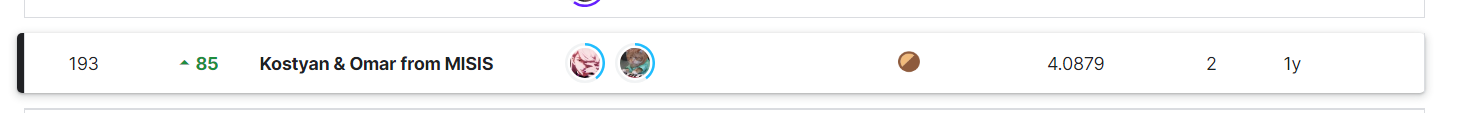

Люди, использующие бустинги сильно улетели вниз на закрытых данных

Многие из топа использовали линейные модели или нейронные сети в этом соревновании, причем простые версии нейронных сетей по типу GRU вместо LSTM